In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deepsky.data import load_storm_patch_data
from keras.layers import Conv2D, MaxPool2D, Dense, Input, Flatten, Dropout, BatchNormalization, Activation, LeakyReLU, AveragePooling2D
from keras.models import Model, save_model, load_model
from keras.optimizers import SGD, Adam
from os.path import join
import keras.backend as K
from keras.regularizers import l2, l1
from deepsky.metrics import brier_skill_score, roc_auc
from IPython.display import Image
from ipywidgets import interact
from glob import glob

# Data Loading

Load reflectivity and hail label data from netCDF files.

In [5]:
refl_vars = ["reflectivity_1000_m_above_ground_prev",
            "reflectivity_4000_m_above_ground_prev"]
storm_data, storm_meta = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", refl_vars, 4)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/scratch/dgagne/ncar_ens_storm_patches/ncar

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_05.nc 1305
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_06.nc 1260
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_07.nc 1265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_08.nc 1270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_09.nc 1185
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_10.nc 1470
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_02.nc 1140
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_03.nc 995
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_04.nc 825
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_05.nc 1025
/scratch/dgagne/ncar_ens_storm_pat

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_09.nc 1685
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_10.nc 1770
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_01.nc 1985
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_02.nc 2170
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_03.nc 2220
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_04.nc 2065
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_05.nc 2160
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_06.nc 2530
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_07.nc 2415
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_08.nc 2270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_09.nc 1870
/scratch/dgagne/ncar_ens_storm_p

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_03.nc 2265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_04.nc 2430
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_05.nc 2695
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_06.nc 2200
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_07.nc 2050
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_08.nc 2400
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_09.nc 2395
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_10.nc 2805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_01.nc 2000
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_02.nc 1850
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_03.nc 1955
/scratch/dgagne/ncar_ens_storm_p

In [6]:
output_data, output_meta = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/",
                                                     ["thompson_max_hail_k1_surface_current",
                                                      "mask"], 4)
max_hail = np.array([output_data[i, :, :, 0][output_data[i, :, :, 1] > 0].max()
                         for i in range(output_data.shape[0])])
max_hail *= 1000
hail_labels = np.where(max_hail >= 25, 1, 0)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc 640
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc 950
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc 650
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc 605
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc 835
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc 760
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc 805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc 900
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc 700
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc 460
/scratch/dgagne/ncar_ens_storm_patches/ncar

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_05.nc 1305
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_06.nc 1260
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_07.nc 1265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_08.nc 1270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_09.nc 1185
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_01.nc 1020
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051200_mem_10.nc 1470
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_02.nc 1140
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_03.nc 995
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_04.nc 825
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016051300_mem_05.nc 1025
/scratch/dgagne/ncar_ens_storm_pat

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_10.nc 1770
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052100_mem_09.nc 1685
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_01.nc 1985
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_02.nc 2170
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_04.nc 2065
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_03.nc 2220
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_05.nc 2160
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_06.nc 2530
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_07.nc 2415
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_08.nc 2270
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052200_mem_09.nc 1870
/scratch/dgagne/ncar_ens_storm_p

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_03.nc 2265
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_04.nc 2430
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_05.nc 2695
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_06.nc 2200
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_07.nc 2050
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_08.nc 2400
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_09.nc 2395
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016053100_mem_10.nc 2805
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_01.nc 2000
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_02.nc 1850
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016060100_mem_03.nc 1955
/scratch/dgagne/ncar_ens_storm_p

Save data to npz and csv files for easy reloading (much faster). 

In [7]:
np.savez("/scratch/dgagne/radar_hail_results_20180307/storm_data.npz", storm_data)
storm_meta.to_csv("/scratch/dgagne/radar_hail_results_20180307/storm_meta.csv", index=False)
hail_frame = pd.DataFrame({"hail_size": max_hail, "is_severe": hail_labels})
hail_frame.to_csv("/scratch/dgagne/radar_hail_results_20180307/hail_labels.csv", index_label="Index")

If data has been saved properly, then the files can be loaded from disk here.

In [4]:
storm_data = np.load("/scratch/dgagne/radar_hail_results_20180307/storm_data.npz")
storm_meta = pd.read_csv("/scratch/dgagne/radar_hail_results_20180307/storm_meta.csv")
hail_frame = pd.read_csv("/scratch/dgagne/radar_hail_results_20180307/hail_labels.csv")
max_hail = hail_frame["hail_size"].values
hail_labels = hail_frame["is_severe"].values

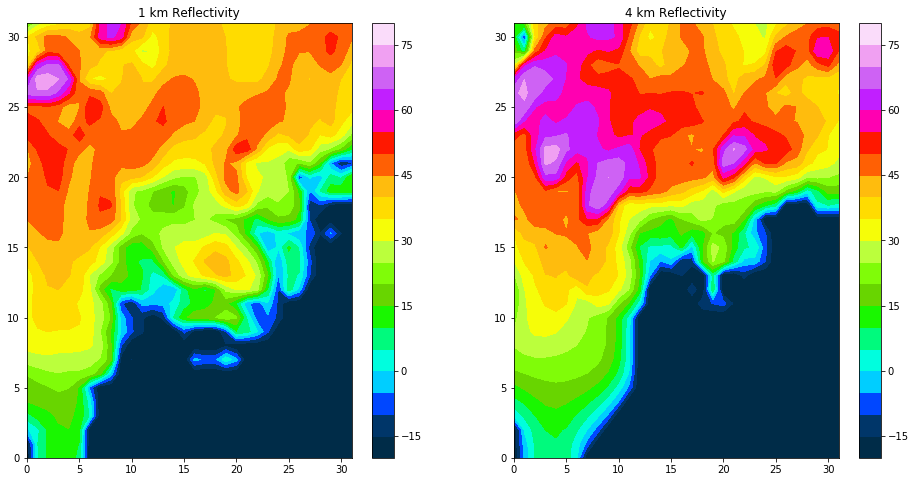

In [12]:
plot_ind = 53431
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.contourf(storm_data[plot_ind, :, :, 0], np.arange(-20, 85, 5), cmap="gist_ncar", vmin=-20, vmax=80)
plt.title("1 km Reflectivity")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.contourf(storm_data[plot_ind, :, :, 1], np.arange(-20, 85, 5), cmap="gist_ncar", vmin=-20, vmax=80)
plt.title("4 km Reflectivity")
plt.colorbar()

In [13]:
s_min = storm_data[:, :, :, 1].min()
s_max = storm_data[:, :, :, 1].max()
s_range = s_max - s_min
norm_data = 2 * (storm_data[:, :, :, 1:2] - s_min) / s_range - 1
print(norm_data.shape, norm_data.max(), norm_data.min())

(114229, 32, 32, 1) 1.0 -1.0


In [26]:
def hail_conv_net(data_width=32, num_input_channels=1, filter_width=5, min_conv_filters=16,
                  filter_growth_rate=2, min_data_width=4,
                  dropout_alpha=0, activation="relu", regularization_alpha=0.01, optimizer="sgd",
                  learning_rate=0.001, loss="mse", metrics=("mae", "auc"), **kwargs):
    device = "/gpu:0"
    with K.tf.device(device):
        cnn_input = Input(shape=(data_width, data_width, num_input_channels))
        num_conv_layers = int(np.log2(data_width) - np.log2(min_data_width))
        num_filters = min_conv_filters
        cnn_model = cnn_input
        for c in range(num_conv_layers):
            cnn_model = Conv2D(num_filters, (filter_width, filter_width), strides=1, padding="same",
                               kernel_regularizer=l2(regularization_alpha))(cnn_model)
            if activation == "leaky":
                cnn_model = LeakyReLU(0.1)(cnn_model)
            else:
                cnn_model = Activation(activation)(cnn_model)
            #cnn_model = BatchNormalization()(cnn_model)
            #cnn_model = Dropout(dropout_alpha)(cnn_model)
            cnn_model = AveragePooling2D(padding="same")(cnn_model)
            num_filters = int(num_filters * filter_growth_rate)
        cnn_model = Flatten()(cnn_model)
        cnn_model = Dense(1, kernel_regularizer=l2(regularization_alpha))(cnn_model)
        cnn_model = Activation("sigmoid")(cnn_model)
        cnn_model_complete = Model(cnn_input, cnn_model)
    if optimizer.lower() == "sgd":
        opt = SGD(lr=learning_rate, decay=1e-6, momentum=0.99, nesterov=True)
    else:
        opt = Adam(lr=learning_rate, beta_1=0.5)
    cnn_model_complete.compile(optimizer=opt, loss=loss, metrics=metrics)
    return cnn_model_complete

In [15]:
seed = 53432
np.random.seed(seed)
train_split = 22
run_dates = storm_meta["run_dates"].unique()
perm_run_dates = np.random.permutation(run_dates)
train_dates = np.sort(perm_run_dates[:train_split])
test_dates = np.sort(perm_run_dates[train_split:])
print(train_dates)
print(test_dates)
train_i = np.where(np.in1d(storm_meta["run_dates"].values, train_dates))[0]
test_i = np.where(np.in1d(storm_meta["run_dates"].values, test_dates))[0]
print(train_i)
print(test_i)

['2016050300' '2016050400' '2016050600' '2016050700' '2016050800'
 '2016050900' '2016051100' '2016051200' '2016051300' '2016051500'
 '2016051800' '2016051900' '2016052000' '2016052200' '2016052300'
 '2016052400' '2016052600' '2016052700' '2016052800' '2016060100'
 '2016060200' '2016060300']
['2016050500' '2016051000' '2016051400' '2016051600' '2016051700'
 '2016052100' '2016052500' '2016052900' '2016053000' '2016053100']
[     0      1      2 ..., 114226 114227 114228]
[  2303   2304   2305 ..., 103217 103218 103219]


In [27]:
session = K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=False,
                                                    gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                    log_device_placement=False))
K.set_session(session)
hail_cnn = hail_conv_net(num_input_channels=1, min_data_width=4, dropout_alpha=0.2, 
                         min_conv_filters=8, filter_width=5, filter_growth_rate=2, 
                         regularization_alpha=0.001, metrics=[])
out_log = hail_cnn.fit(norm_data[train_i], hail_labels[train_i], epochs=10, validation_split=0, )

Epoch 1/10
78326/78326 [==============================] - 13s 160us/step - loss: 0.1625
Epoch 2/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 3/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1254
Epoch 4/10
78326/78326 [==============================] - 12s 155us/step - loss: 0.1215
Epoch 5/10
78326/78326 [==============================] - 12s 155us/step - loss: 0.1200
Epoch 6/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1191
Epoch 7/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1189
Epoch 8/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1181
Epoch 9/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1181
Epoch 10/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1179


In [13]:
hail_cnn_random = hail_conv_net(num_input_channels=1, min_data_width=4, dropout_alpha=0.2, 
                         min_conv_filters=8, filter_width=5, filter_growth_rate=2, 
                         regularization_alpha=0.001, metrics=[])
out_log = hail_cnn_random.fit(norm_data[train_i], np.random.permutation(hail_labels[train_i]), epochs=10, validation_split=0, )

Epoch 1/10
78326/78326 [==============================] - 18s 230us/step - loss: 0.1613
Epoch 2/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1427
Epoch 3/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1375
Epoch 4/10
78326/78326 [==============================] - 12s 156us/step - loss: 0.1356
Epoch 5/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1349
Epoch 6/10
78326/78326 [==============================] - 12s 157us/step - loss: 0.1346
Epoch 7/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 8/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 9/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345
Epoch 10/10
78326/78326 [==============================] - 12s 158us/step - loss: 0.1345


In [14]:
cnn_random_preds = hail_cnn_random.predict(norm_data[test_i])[:, 0]
print(brier_skill_score(hail_labels[test_i], cnn_random_preds))
print(roc_auc(hail_labels[test_i], cnn_random_preds))

-0.0148799238515
-0.0


In [23]:
sess_old = K.get_session()
sess_old.close()

In [28]:
cnn_preds = hail_cnn.predict(norm_data[test_i])[:, 0]
print(brier_skill_score(hail_labels[test_i], cnn_preds))
print(roc_auc(hail_labels[test_i], cnn_preds))

0.144969900105
0.744400744532


(array([ 16634.,  12949.,   2787.,   1333.,    784.,    547.,    409.,
           277.,    144.,     39.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

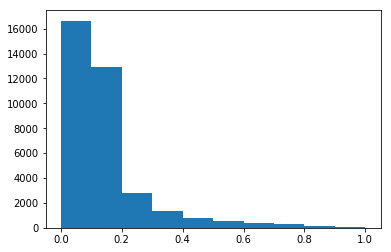

In [29]:
plt.hist(cnn_preds, np.arange(0, 1.1, 0.1))

In [31]:
out_path = "/scratch/dgagne/radar_hail_results_20180307/"


In [228]:
save_model(hail_cnn, join(out_path, "radar_cnn.h5"))

In [33]:
def visualize_layer(cnn_model, out_prob, max_iter=5, min_loss=0.001, step=0.1, dropout=False):
    layer_out = cnn_model.output
    input_image = cnn_model.layers[0].input
    loss = 0.5 * (K.constant(out_prob) - layer_out) ** 2
    grads = K.gradients(loss, input_image)[0]
    grads /= K.maximum(K.std(grads), K.epsilon())
    #grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [loss, grads])
    
    #input_img_data = np.ones(shape=(1, 32, 32, 1)) * -1
    input_img_data = np.random.normal(scale=0.1, size=(1, 32, 32, 1))
    #input_img_data = np.random.normal(size=(1, 32, 32, 15)) * 0.1
    loss_val = 2
    num_iter = 0
    while num_iter < max_iter and loss_val > 0.01:
        loss_value, grads_value = iterate([input_img_data, dropout])
        loss_val = loss_value[0, 0]
        print(loss_value, grads_value.max(), grads_value.min())
        input_img_data -= grads_value * step
        #input_img_data[input_img_data > 1] = 1
        #input_img_data[input_img_data < -1] = -1
        num_iter += 1
    return input_img_data

In [34]:
out_storm = visualize_layer(hail_cnn, 1, max_iter=1000, min_loss=0.001, step=0.01, dropout=False)
out_storm.max(), out_storm.min()

[[ 0.45742968]] 2.88661 -0.793053
[[ 0.45442921]] 2.87364 -0.77328
[[ 0.45122582]] 2.87371 -0.782095
[[ 0.44782054]] 2.87343 -0.791655
[[ 0.44437999]] 3.09742 -0.915814
[[ 0.44109827]] 3.17326 -1.11189
[[ 0.43819171]] 3.2157 -1.27273
[[ 0.43569511]] 2.5474 -1.58575
[[ 0.43350005]] 2.39068 -1.76161
[[ 0.43152693]] 1.93224 -1.95126
[[ 0.42965823]] 1.81373 -2.14905
[[ 0.42784774]] 1.68506 -2.23584
[[ 0.42611641]] 1.67126 -2.7674
[[ 0.42445636]] 1.76074 -3.64239
[[ 0.42280754]] 1.6739 -3.87418
[[ 0.4210417]] 1.40188 -4.92012
[[ 0.41869214]] 0.863081 -5.89981
[[ 0.41462383]] 0.571972 -6.49647
[[ 0.4081299]] 0.339398 -7.00076
[[ 0.39680618]] 0.687945 -7.12437
[[ 0.38038525]] 0.722197 -6.90625
[[ 0.35963207]] 0.719165 -6.66632
[[ 0.33516288]] 0.799388 -6.46166
[[ 0.30763391]] 0.746831 -6.37303
[[ 0.27786973]] 0.686908 -6.34641
[[ 0.24750537]] 0.746429 -6.32488
[[ 0.21761149]] 0.731503 -6.36538
[[ 0.18834978]] 0.730995 -6.27058
[[ 0.16039972]] 0.70411 -6.07214
[[ 0.13366456]] 0.679188 -6.03858

(1.7558594010391952, -0.61640697929378652)

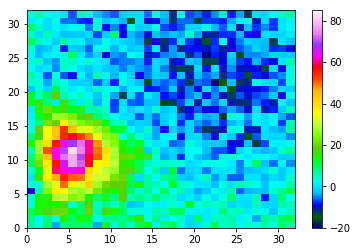

In [35]:
rescaled_storm = 2 * (out_storm - out_storm.min()) / (out_storm.max() - out_storm.min()) - 1
plt.pcolormesh((rescaled_storm[0, :, :, 0] + 1) / 2 * s_range + s_min, vmin=-20, vmax=85,
              cmap="gist_ncar")
plt.colorbar()

In [23]:
out_storm.max(), out_storm.min()

(5.1667475202201398, -2.5660035099571239)

In [175]:
rescaled_storm.min()

-1.0

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    1.,    1.,    1.,
           0.,    0.,    0.,    0.,    2.,    2.,    0.,    3.,    2.,
           1.,    1.,    1.,    3.,    2.,    2.,    2.,    3.,    2.,
           0.,    5.,    4.,    3.,    7.,    4.,    4.,    8.,    8.,
           8.,    6.,   21.,   26.,  193.,   25.,   32.,   19.,   18.,
          17.,    6.,    2.,   12.,    4.,    5.,   10.,    2.,    3.,
           2.,    1.,    4.,    1.,    1.,    2.,    1.,    2.,    4.,
           2.,    0.,    0.,    3.,    0.,    0.,    0.,    1.,    1.,
           1.,    0.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([-0.2564677 , -0.25127571, -0.24608372, -0.24089173, -0.23569974,
        -0.23050775, -0.22531576, -0.22012378, -0.21493179, -0.2097398 ,
        -0.20454781, -0.19935582, -0.19416383, -0.18897184, -0.1

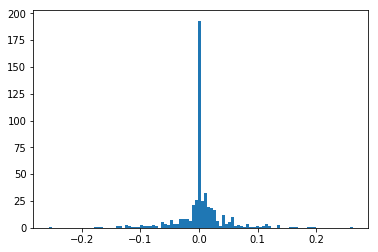

In [37]:
plt.hist(hail_cnn.layers[-2].get_weights()[0].ravel(), bins=100)

In [44]:
np.count_nonzero(np.abs(hail_cnn.layers[-2].get_weights()[0]) < 1e-3)

169

In [41]:
weights = hail_cnn.layers[-2].get_weights()[0].ravel()
num_top = 36
num_ex = 9
top_neurons = weights.argsort()[::-1][0:num_top]
top_examples = np.zeros((num_top, num_ex), dtype=int)
top_gradients = np.zeros((num_top, num_ex, 32, 32, 1))
for n, neuron in enumerate(top_neurons):
    print(n, neuron, weights[neuron])
    act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:, neuron]])
    loss = 0.5 * (hail_cnn.layers[-3].output[:, neuron] - 4) ** 2
    grads = K.gradients(loss, hail_cnn.input)[0]
    grads /= K.maximum(K.std(grads), K.epsilon())
    #grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    grad_func = K.function([hail_cnn.input, K.learning_phase()], [grads])
    act_values = act_func([norm_data, 0])[0]
    top_examples[n] = act_values.argsort()[::-1][0:num_ex]
    top_gradients[n] = -grad_func([norm_data[top_examples[n]],0])[0]

0 166 0.262731
1 294 0.195247
2 313 0.192711
3 198 0.188266
4 134 0.167518
5 318 0.162437
6 345 0.157771
7 302 0.137276
8 326 0.136892
9 334 0.132993
10 176 0.122213
11 174 0.120325
12 297 0.115763
13 190 0.113731
14 478 0.11277
15 350 0.112384
16 153 0.111044
17 281 0.108232
18 185 0.103816
19 315 0.0994316
20 6 0.0988675
21 304 0.0914483
22 144 0.0894921
23 325 0.084091
24 293 0.0837991
25 262 0.0829325
26 265 0.0812579
27 208 0.0782813
28 441 0.0749792
29 425 0.0710066
30 446 0.070024
31 329 0.0684042
32 272 0.0676342
33 418 0.0646627
34 475 0.0628739
35 295 0.0589893


In [84]:
bot_neurons = weights.argsort()[0:num_top]
bot_examples = np.zeros((num_top, num_ex), dtype=int)
bot_gradients = np.zeros((num_top, num_ex, 32, 32, 1))
for n, neuron in enumerate(bot_neurons):
    print(n, neuron, weights[neuron])
    act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:, neuron]])
    loss = 0.5 * (hail_cnn.layers[-3].output[:, neuron] - 4) ** 2
    grads = K.gradients(loss, hail_cnn.input)[0]
    grads /= K.maximum(K.std(grads), K.epsilon())
    #grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())
    grad_func = K.function([hail_cnn.input, K.learning_phase()], [grads])
    act_values = act_func([norm_data, 0])[0]
    bot_examples[n] = act_values.argsort()[::-1][0:num_ex]
    bot_gradients[n] = -grad_func([norm_data[bot_examples[n]],0])[0]

0 314 -0.256468
1 346 -0.17482
2 168 -0.171026
3 189 -0.164677
4 186 -0.142147
5 317 -0.138524
6 282 -0.133462
7 308 -0.132436
8 442 -0.124105
9 474 -0.123884
10 305 -0.12354
11 465 -0.118802
12 337 -0.118783
13 154 -0.112802
14 339 -0.108008
15 433 -0.104132
16 157 -0.0995028
17 467 -0.0987213
18 136 -0.0980838
19 422 -0.0946671
20 296 -0.0928589
21 180 -0.088076
22 148 -0.0859027
23 307 -0.0837705
24 200 -0.0819349
25 191 -0.0776364
26 276 -0.0771664
27 371 -0.0764276
28 221 -0.0733369
29 285 -0.0698997
30 349 -0.0640224
31 218 -0.0617901
32 211 -0.0608535
33 273 -0.0607832
34 435 -0.0600084
35 499 -0.0589027


In [79]:
all_act_func = K.function([hail_cnn.input, K.learning_phase()], [hail_cnn.layers[-3].output[:]])
out_acts = all_act_func([norm_data[test_i],0])[0]
aucs = np.zeros(weights.shape)
for a in range(aucs.size):
    if weights[a] >= 0:
        aucs[a] = roc_auc(hail_labels[test_i], out_acts[:, a])
    else:
        aucs[a] = roc_auc(hail_labels[test_i], out_acts[:, a].max() -out_acts[:, a])

(array([  1.30000000e+01,   4.20000000e+01,   1.46000000e+02,
          3.66000000e+02,   1.16500000e+03,   1.82300000e+03,
          3.91200000e+03,   1.86110000e+04,   7.95200000e+03,
          1.87300000e+03]),
 array([ 0.16015625,  0.17285156,  0.18554688,  0.19824219,  0.2109375 ,
         0.22363281,  0.23632812,  0.24902344,  0.26171875,  0.27441406,
         0.28710938]),
 <a list of 10 Patch objects>)

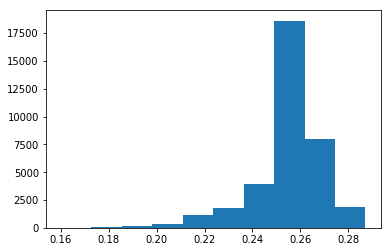

In [105]:
plt.hist(np.where((weights < 0) & (out_acts > 0), 1, 0).sum(axis=1) / 512)

/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/scratch/dgagne/miniconda3/envs/deep36/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


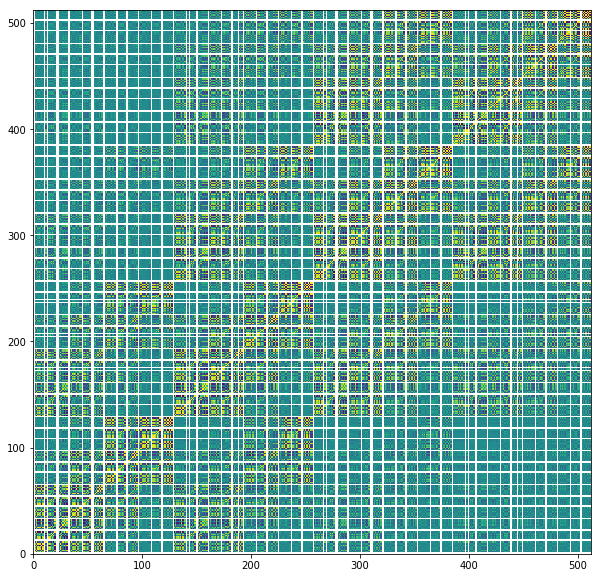

In [108]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(np.corrcoef(out_acts.T))

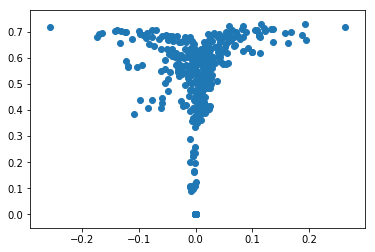

In [82]:
plt.scatter(weights, aucs)


In [392]:
np.count_nonzero(weights > 0)

262

In [386]:
for neur in range(num_top):
    print(neur)
    fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
    plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    axef = axes.ravel()
    for a, ax in enumerate(axef):
        cont = ax.contourf(storm_data[top_examples[neur, a], :, :, 2], 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
        ax.set_facecolor('0.6')
        v_min = top_gradients[neur, a, :, :, 0].min()
        v_max = top_gradients[neur, a, :, :, 0].max()
        scale_max = np.maximum(-v_min, v_max)
        ax.contour(top_gradients[neur, a, :, :, 0], [v_min /2, v_min / 4, v_max /4, v_max / 2], 
                   vmin=-scale_max, vmax=scale_max, cmap="RdBu", linewidths=3)
        ax.set_xticks(np.arange(8, 32, 8))
        ax.set_xticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.set_yticks(np.arange(8, 32, 8))
        ax.set_yticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.text(1, 2, storm_meta.loc[top_examples[neur, a], "valid_dates"].strftime("%y-%m-%d H%H"))
        ax.text(16, 2, "Hail Size: {0:02.0f} mm".format(max_hail[top_examples[neur, a]]))
    axes[2, 1].set_xlabel("X Distance (km)", fontsize=14)
    axes[1, 0].set_ylabel("Y Distance (km)", fontsize=14)
    cbar = fig.colorbar(cont, cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel("4 km Height Radar Reflectivity (dBZ)", fontsize=14)
    fig.suptitle("Top Activated Examples and Interest Regions for Neuron {0:d} Rank {1:d}".format(top_neurons[neur], neur + 1), fontsize=14)
    plt.savefig(join(out_path, "radar_cnn_top_act_neuron_{0:03d}.png".format(neur + 1)), dpi=200, bbox_inches="tight")
    plt.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [93]:
neur = 0
for neur in range(num_top):
    print(neur)
    fig, axes = plt.subplots(3, 3, figsize=(8, 8), sharex=True, sharey=True)
    plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
    cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
    axef = axes.ravel()
    for a, ax in enumerate(axef):
        rad_img = storm_data[top_examples[neur, a], :, :, 1]
        cont = ax.pcolormesh(np.ma.array(rad_img, mask=rad_img < -10), cmap="gist_ncar", vmin=-10, vmax=80)
        #cont = ax.contourf(storm_data[top_examples[neur, a], :, :, 2], 
        #                   np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
        ax.set_facecolor('0.6')
        v_min = top_gradients[neur, a, :, :, 0].min()
        v_max = top_gradients[neur, a, :, :, 0].max()
        scale_max = np.maximum(-v_min, v_max)
        print(v_min, v_max)
        ax.contour(top_gradients[neur, a, :, :, 0], [v_min /2, v_min / 4, v_max /4, v_max / 2], 
                   vmin=-scale_max, vmax=scale_max, cmap="RdBu", linewidths=3)
        ax.set_xticks(np.arange(8, 32, 8))
        ax.set_xticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.set_yticks(np.arange(8, 32, 8))
        ax.set_yticklabels(np.arange(8, 32, 8) * 3, fontsize=14)
        ax.text(1, 2, storm_meta.loc[top_examples[neur, a], "valid_dates"].strftime("%y-%m-%d H%H"))
        ax.text(16, 2, "Hail Size: {0:02.0f} mm".format(max_hail[top_examples[neur, a]]))
    axes[2, 1].set_xlabel("X Distance (km)", fontsize=14)
    axes[1, 0].set_ylabel("Y Distance (km)", fontsize=14)
    cbar = fig.colorbar(cont, cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_ylabel("4 km Height Radar Reflectivity (dBZ)", fontsize=14)
    fig.suptitle("Top Activated Examples and Interest Regions for Neuron {0:d} Rank {1:d}".format(top_neurons[neur], neur + 1), fontsize=14)
    plt.savefig(join(out_path, "radar_cnn_top_act_neuron_pc_{0:03d}.png".format(neur + 1)), dpi=200, bbox_inches="tight")
    plt.close()

0
-0.376254141331 3.95466899872
-0.608960986137 4.60965013504
-0.714523077011 4.77930641174
-0.581401050091 5.0763297081
-0.562852442265 5.03040504456
-0.919314980507 5.11363554001
-0.520773172379 5.41542243958
-0.675500810146 5.39569473267
-0.717120110989 5.27491521835
1
-0.71620965004 4.27630376816
-0.558136641979 4.38692045212
-0.937213182449 4.10096359253
-0.810148179531 4.50972270966
-1.00324106216 5.1278553009
-0.682376027107 5.08993387222
-0.636691451073 5.06129312515
-1.01847207546 5.45205593109
-0.590832293034 4.48524284363
2
-0.83968681097 4.21030664444
-0.626460671425 4.25699567795
-0.44232904911 4.07771348953
-0.708987951279 4.54796600342
-0.954959154129 4.2164311409
-0.6844176054 4.71858119965
-0.806157529354 4.50193452835
-0.630039334297 4.61472034454
-0.769271016121 4.51064920425
3
-0.687372803688 4.29364538193
-0.645084381104 4.25768756866
-0.687220990658 4.22406339645
-0.659547269344 5.1389093399
-0.739475607872 5.18580436707
-0.887737512589 5.10771560669
-0.7216779589

31
-0.751324057579 4.48378944397
-0.728067338467 4.15975809097
-0.756486415863 4.54250717163
-0.851153790951 4.31626176834
-0.888276338577 4.88006877899
-0.801448047161 4.21071720123
-0.499891012907 4.69193124771
-0.636733651161 4.84313488007
-0.874171853065 4.26315116882
32
-0.889237344265 4.78468036652
-1.02002978325 5.28502178192
-1.04806447029 4.99573421478
-0.971894562244 4.84913396835
-0.751980960369 5.48948478699
-0.995452880859 4.61344337463
-0.894451797009 5.51937246323
-0.519567787647 5.5621137619
-0.966866493225 4.79473304749
33
-1.05154454708 4.94934844971
-0.978576898575 5.05371189117
-0.908369481564 4.76006412506
-0.66343909502 5.25533008575
-0.982002139091 5.03426122665
-1.01323235035 5.18495130539
-0.677695930004 5.42482995987
-0.413462132215 5.56869077682
-0.491168349981 5.6283416748
34
-0.678303718567 5.32662963867
-0.748461186886 5.23879384995
-1.08643090725 5.6497964859
-0.641774177551 5.25582742691
-1.19375932217 5.19117879868
-1.06433820724 5.57763624191
-0.936166

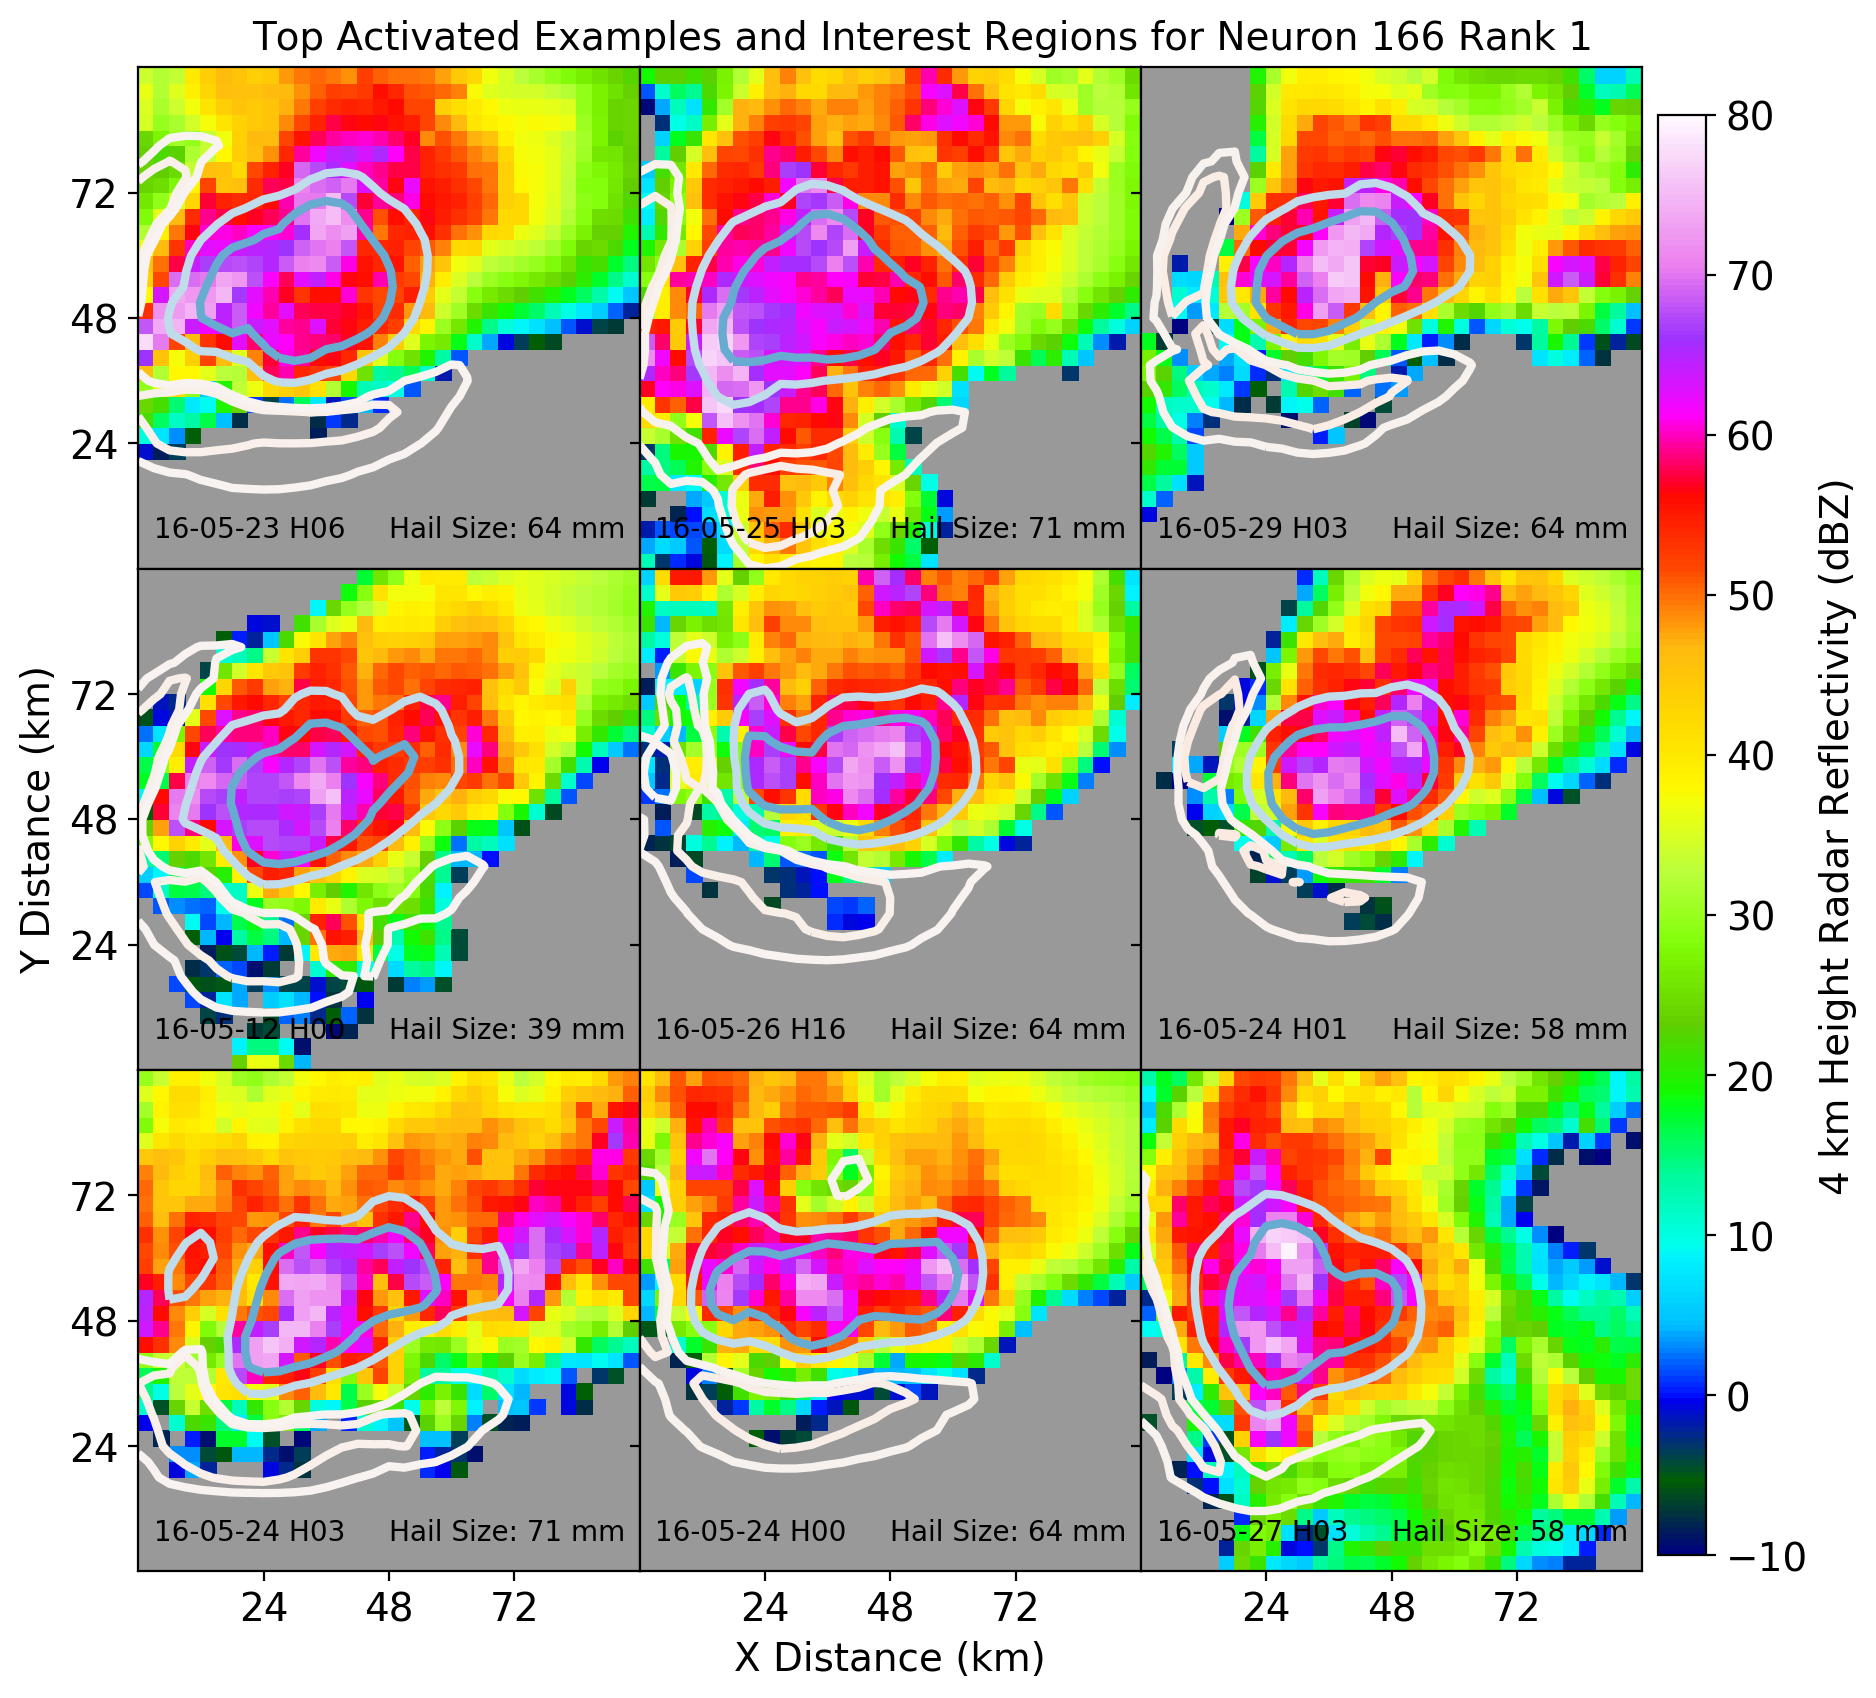

In [99]:


img_files = sorted(glob(join(out_path, "radar_cnn_top_act_neuron_pc_*.png")))
Image(img_files[0])

In [362]:
storm_meta.loc[5, "valid_dates"].strftime("%Y-%m-%d %H")

'2016-05-03 13'

In [85]:
mean_grads = top_gradients.mean(axis=1)[:, :, :, 0]
bot_mean_grads = bot_gradients.mean(axis=1)[:, :, :, 0]

In [26]:
mean_grads.min()

-4.0984136263529463

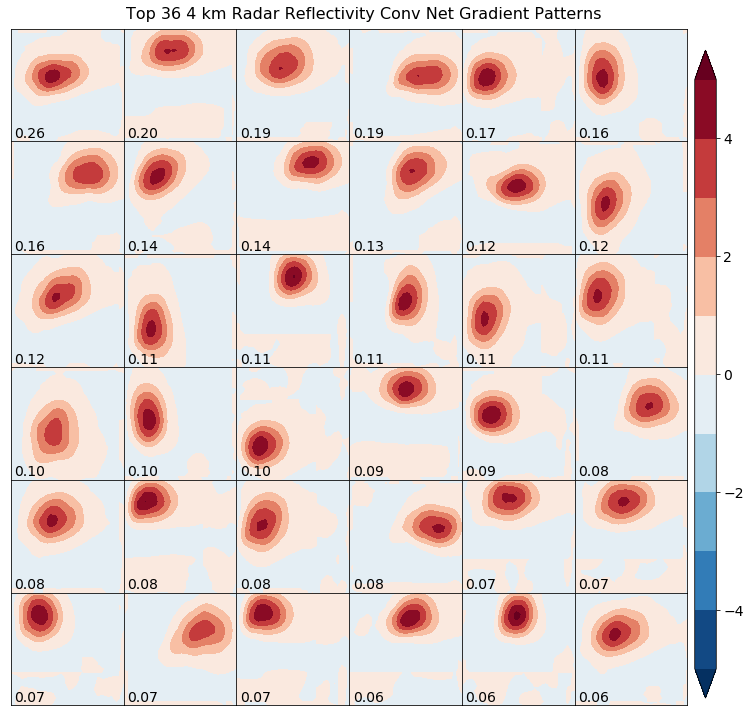

In [47]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(mean_grads[a], np.arange(-5, 6), extend="both", cmap="RdBu_r")
    ax.text(1, 1, "{0:0.2f}".format(weights[top_neurons[a]]), fontsize=14)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Top 36 4 km Radar Reflectivity Conv Net Gradient Patterns", fontsize=16)
plt.savefig(join(out_path, "top_36_radar_cnn_grads.png"), dpi=200, bbox_inches="tight")

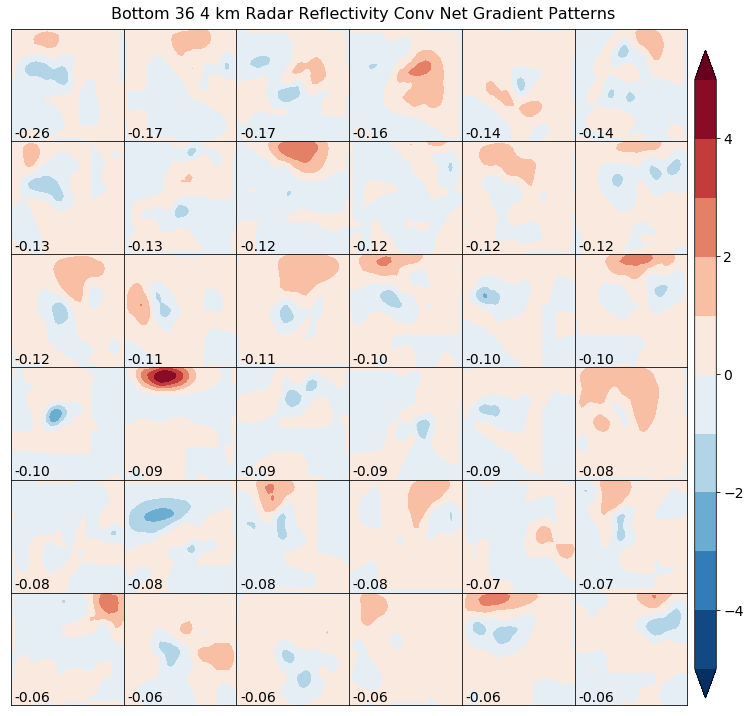

In [86]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(bot_mean_grads[a], np.arange(-5, 6), extend="both", cmap="RdBu_r")
    ax.text(1, 1, "{0:0.2f}".format(weights[bot_neurons[a]]), fontsize=14)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Bottom 36 4 km Radar Reflectivity Conv Net Gradient Patterns", fontsize=16)
plt.savefig(join(out_path, "bot_36_radar_cnn_grads.png"), dpi=200, bbox_inches="tight")

In [402]:
mean_grads.min()

-11.469572385152182

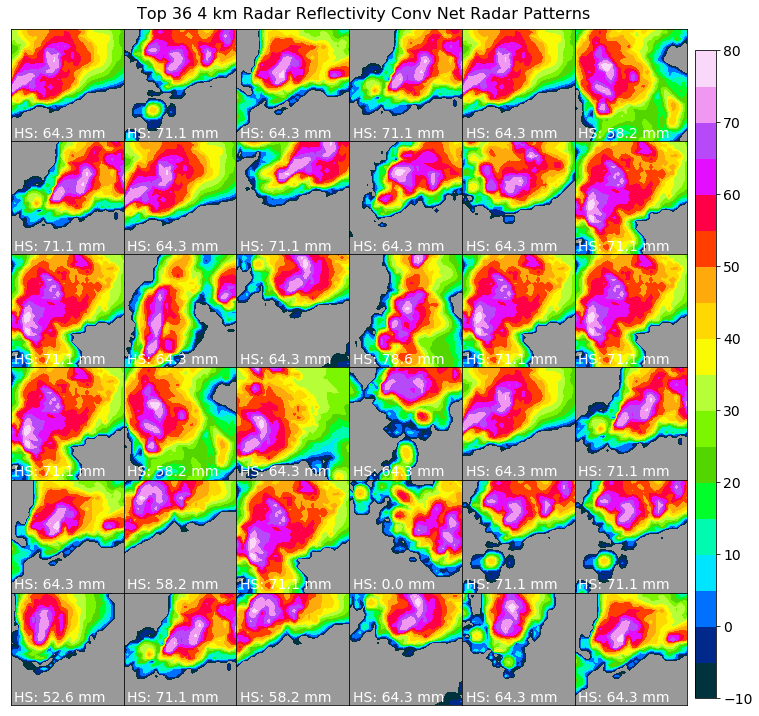

In [91]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)

axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(storm_data[top_examples[a, 0], :, :, 1], 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
    ax.set_facecolor('0.6')
    ax.text(1, 1, "HS: {0:0.1f} mm".format(max_hail[top_examples[a, 0]]), fontsize=14, color="w")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Top 36 4 km Radar Reflectivity Conv Net Radar Patterns", fontsize=16)
plt.savefig(join(out_path, "top_36_radar_cnn_refl.png"), dpi=200, bbox_inches="tight")

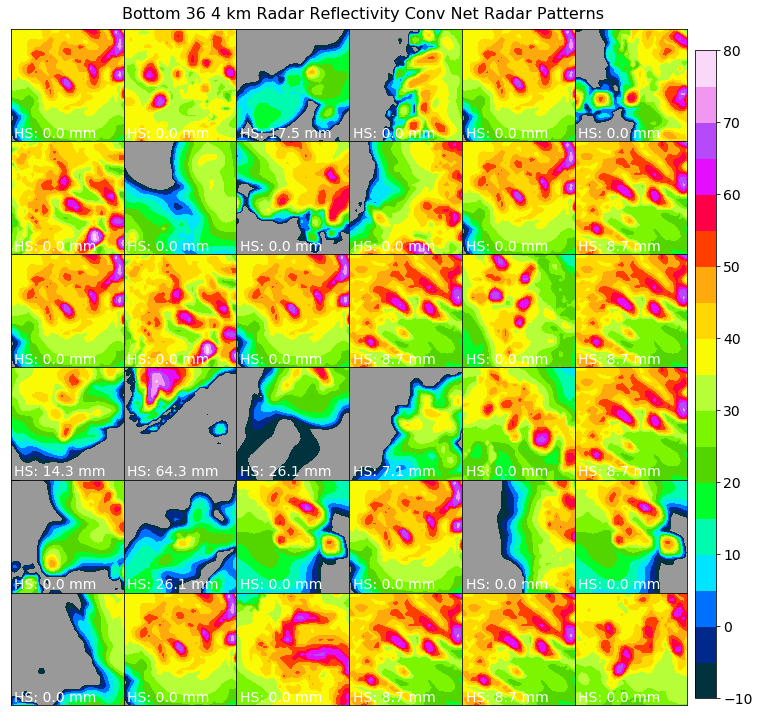

In [90]:
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, hspace=0, wspace=0)
cax = fig.add_axes([0.96, 0.02, 0.03, 0.9])
axef = axes.ravel()
for a, ax in enumerate(axef):
    cont = ax.contourf(storm_data[bot_examples[a, 0], :, :, 1], 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
    ax.set_facecolor('0.6')
    ax.text(1, 1, "HS: {0:0.1f} mm".format(max_hail[bot_examples[a, 0]]), fontsize=14, color="w")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Bottom 36 4 km Radar Reflectivity Conv Net Radar Patterns", fontsize=16)
plt.savefig(join(out_path, "bot_36_radar_cnn_refl.png"), dpi=200, bbox_inches="tight")

In [111]:
hail_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 8)         208       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 8)         0         
_________________________________________________________________
average_pooling2d_4 (Average (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 16)        3216      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 8, 8, 16)          0         
__________

In [213]:
hail_net_diag = K.function([hail_cnn.input], 
                           [hail_cnn.layers[3].output, hail_cnn.layers[6].output, hail_cnn.layers[9].output,
                           hail_cnn.output])

In [214]:
diag_out = hail_net_diag([norm_data[top_examples[0, 0:1]]])

In [140]:
rad_img = storm_data[top_examples[0, 0], :, :, 0]

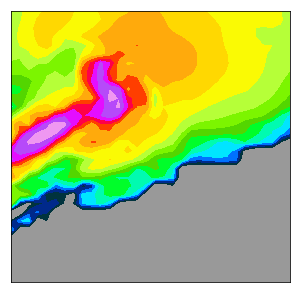

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_facecolor("0.6")
#cont = ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, extend="max", cmap="Blues_r")
cont = ax.contourf(orig_ticks, orig_ticks, rad_img, 
                           np.arange(-10, 85, 5), cmap="gist_ncar", vmin=-10, vmax=80)
#ax.clabel(cont, fontsize=14, fmt="%d")
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_input.png"), dpi=200, bbox_inches="tight")

In [208]:
print(diag_out[0].max(), diag_out[0].min())
print(diag_out[1].max(), diag_out[0].min())
print(diag_out[2].max(), diag_out[0].min())

1.67217 0.0
2.92934 0.0
2.67195 0.0


[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5]


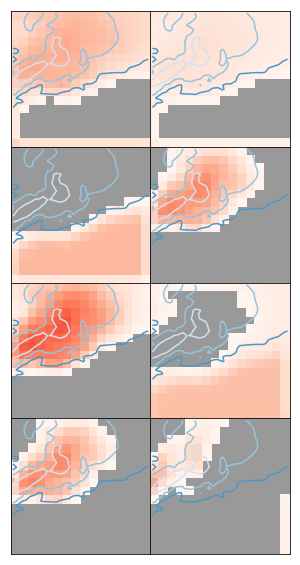

In [222]:
fig, axes = plt.subplots(4, 2, figsize=(5, 10))
plt.subplots_adjust(wspace=0, hspace=0)
orig_ticks = np.linspace(0, 31, 32) + 0.5
ax_ticks = np.linspace(0, 32, 17)
print(orig_ticks)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    act_img = diag_out[0][0, :, :, a]
    ax.pcolormesh(ax_ticks, ax_ticks, np.ma.array(act_img, mask=act_img==0), cmap="Reds", vmin=0, vmax=3)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_act_1.png"), dpi=200, bbox_inches="tight")

[  0.   4.   8.  12.  16.  20.  24.  28.  32.]


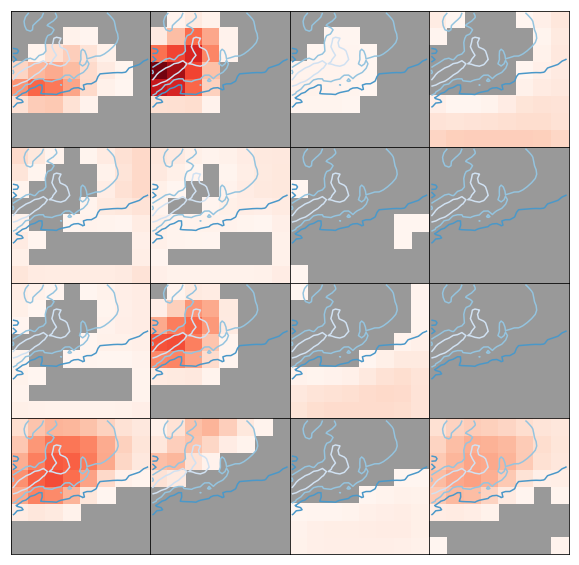

In [223]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 9)
print(ax_ticks)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    act_img = diag_out[1][0, :, :, a]
    ax.pcolormesh(ax_ticks, ax_ticks, np.ma.array(act_img, mask=act_img==0), cmap="Reds", vmin=0, vmax=3)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_act_2.png"), dpi=200, bbox_inches="tight")

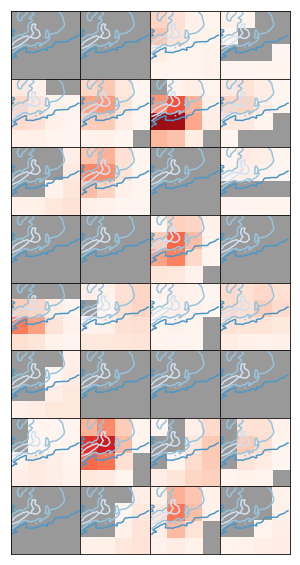

In [224]:
fig, axes = plt.subplots(8, 4, figsize=(5, 10))
plt.subplots_adjust(wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 5)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    act_img = diag_out[2][0, :, :, a]
    ax.pcolormesh(ax_ticks, ax_ticks, np.ma.array(act_img, mask=act_img==0), cmap="Reds", vmin=0, vmax=3)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
plt.savefig(join(out_path, "radar_cnn_conv_act_3.png"), dpi=200, bbox_inches="tight")

In [199]:
weight_mag = hail_cnn.layers[-2].get_weights()[0].reshape(4, 4, 32)

In [203]:
weight_mag.max()

0.26273122

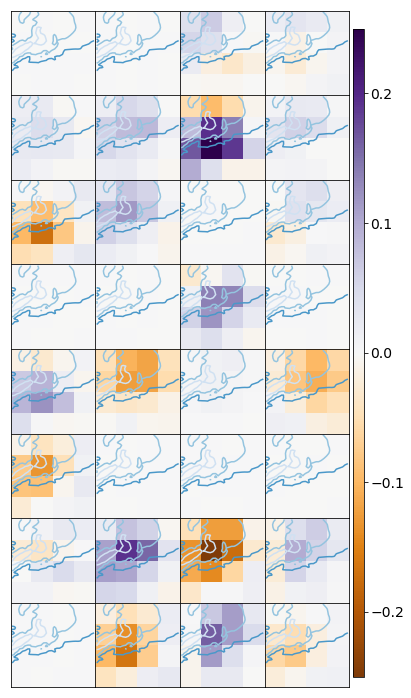

In [226]:
fig, axes = plt.subplots(8, 4, figsize=(5, 10))
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 5)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    ax.pcolormesh(ax_ticks, ax_ticks, weight_mag[:, :, a], cmap="PuOr", vmin=-0.25,vmax=0.25)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cax = fig.add_axes([0.96, 0.025, 0.03, 0.9])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
plt.savefig(join(out_path, "radar_cnn_weight_mag.png"), dpi=200, bbox_inches="tight")

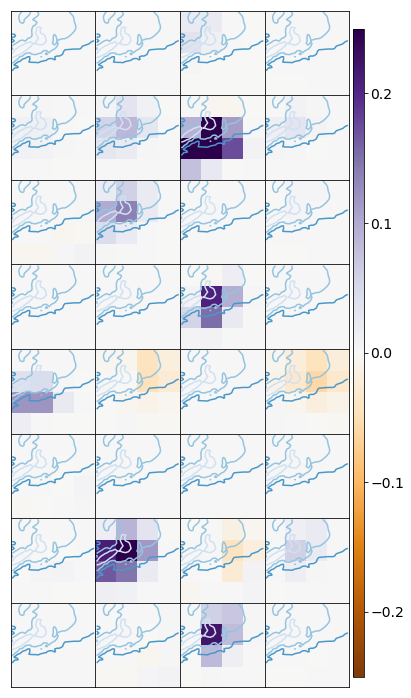

In [227]:
fig, axes = plt.subplots(8, 4, figsize=(5, 10))
plt.subplots_adjust(0.01, 0.01, 0.95, 0.95, wspace=0, hspace=0)
ax_ticks = np.linspace(0, 32, 5)
for a, ax in enumerate(axes.ravel()):
    ax.set_facecolor('0.6')
    cont = ax.pcolormesh(ax_ticks, ax_ticks, weight_mag[:, :, a] * diag_out[2][0, :, :, a], cmap="PuOr", vmin=-0.25,vmax=0.25)
    ax.contour(orig_ticks, orig_ticks, rad_img, [20, 40, 60], vmin=-20, vmax=80, cmap="Blues_r")
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
cax = fig.add_axes([0.96, 0.025, 0.03, 0.9])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
plt.savefig(join(out_path, "radar_cnn_weight_out.png"), dpi=200, bbox_inches="tight")

In [215]:
diag_out[-1]

array([[ 0.98888189]], dtype=float32)